## Import library

In [4]:
import pandas as pd
import pymongo
import matplotlib.pyplot as plt
from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from konlpy.tag import Okt

## MongoDB to DataFrame

In [5]:
# Mongodb 불러오기
import pymongo

# mongodb 연결
conn = pymongo.MongoClient()

# DB접근
db = conn['crawling_review']

# collection 접근
collection = db['movies']

In [6]:
# DataFrame
doc = collection.find_one()
data = pd.DataFrame(doc, columns=['star','comment'])
data.sample(10)

,star,comment
3207,10,자녀의 마음도 부모의 마음도 헤아려볼 수 있었던 좋은 영화
332,9,와우 이런 상상력이라니.
3519,8,
4090,8,브이로그를 보는듯한 느낌이였어요 재밌게 잘 봤습니다 :)
8601,10,피로 비눗방울을 만들어 날려 보내는 장면이 인상적이었어요
9561,5,보통수준
9492,2,식상했음 흔한 느와르. 등장인물들 모두 여자였다면 아무리 흔한 스토리의 느와르라도 ...
6444,10,오랜만에 만난 정말 좋은 영화였습니다. 케이트 블란챗의 연기력은 정말 최고입니다. ...
5556,10,미쳤어요너무재밌어요
8420,2,진짜 다 댓글 알바냐? ㅡㅡ 평점보고 좋아서 봤다가 시간만 날렸다 절대 보지마라 ㅡㅡ


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9990 entries, 0 to 9989
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   star     9990 non-null   object
 1   comment  9990 non-null   object
dtypes: object(2)
memory usage: 156.2+ KB


In [8]:
# data tpye 변경
data = data.astype({'star':'int'})
data.dtypes

star        int32
comment    object
dtype: object

## label 설정

In [9]:
# 평점 7 이상 = 긍정(1)
data_pos = data[data['star']>=7]
data_pos['label'] = 1
data_pos

C:\Users\User\AppData\Local\Temp/ipykernel_18948/2313997164.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_pos['label'] = 1


,star,comment,label
0,10,평점이 낮아서 안보려다 봤는데 보길 정말 잘했슴ㄷㅏ.저는 지루하지않았고 후반부로 갈...,1
1,10,가슴 시리도록 기억에 오래 남을 영화. 공유 전도연의 연기는.. 잊혀지지 않을 것 ...,1
3,9,우리가 자라고 우리가 사랑을 하고 우리가 결혼을 하고 우리가 아이를 키우고 우리가 ...,1
5,7,믿고보는 황정밋 배우!!,1
8,10,으악 ㅋㅋ 너무무서웠어요 ㅠㅠ,1
...,...,...,...
9981,10,굿굿 ㅅ평점왜이러지?,1
9983,10,참신한 주제와 훌륭한 배우들과 연출 좋았습니다 몰입해서 잘 봤어요,1
9986,7,로맨스 영화를 가장한 SF물이라서 뭔가 아쉬움이 남는 영화.개봉당시 포스터만 봐도 ...,1
9987,10,"연출, 연기 다 좋습니다",1


In [10]:
# 평점 6 이하 = 부정(0)
data_neg = data[data['star']<7]
data_neg['label'] = 0
data_neg

C:\Users\User\AppData\Local\Temp/ipykernel_18948/1242165523.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_neg['label'] = 0


,star,comment,label
2,1,대체... 이게 뭐죠?,0
4,1,보는 내가 유체이탈할뻔 보다가 나온 영화는 처음임답답하고 주인공 본인도 몰라 답답한...,0
6,1,고양이가 그렇게 불쌍하시면 데려가서 키우세요. 집없이 밖에서 벌벌떠는 고양이들이 불...,0
7,2,연출 연기 스토리 전부 잘못된 영화,0
9,1,중국 자본인 게 너무 티나서 아쉽다.,0
...,...,...,...
9980,5,재미없음,0
9982,3,"필름을 드라마 찍을때 사용하는 방식으로 찍엇노??? 장혁,유오성 너무 아깝다. 감독...",0
9984,4,강원도사투리가 넘쎄서 영화스타일이랑 안어울림. 뭐라고하는지 원...,0
9985,6,님의 하드캐리,0


In [11]:
# 데이터 합치고 필요없는 column 제거
df = pd.concat([data_pos,data_neg], ignore_index=True)
df.sample(10)

,star,comment,label
5255,8,눈이 즐거운 영화. 그런데 잡지 내용을 글로 읽느라 미장센을 다 즐기지 못해서 아쉬...,1
2646,8,자아실현이 필요한 아줌마들의 힐링 영화.,1
2862,10,진짜 울면서 봤습니다 너무 재밌어요,1
1600,9,1편에는 못따라가지만 재밌었음,1
8669,5,"양아치와 건달의 싸움. 재미있게 봤음. 주조연과 단역의 연기는 좋았는데,당최 왜 장...",0
6595,10,"전 재미있게 봤네요. ㅎㅎ대사도 좋고...""아직 오지 않은 것을 기다리며 알 수...",1
1110,7,좀 졸았지만 영화는 정말 예쁘다 마지막 애니메이션이 좋았음,1
6592,10,진짜 재밋게봤음 음악스토리영상다좋음,1
4689,10,오랜만에 새로운 국산 애니가 나온 소식을 접하게 되어 매우 기쁜 것 같습니다. 몇 ...,1
2552,10,너무 좋은 영화에요 이런 영화를 만들어주셔서 감사합니다,1


1    6924
0    3066
Name: label, dtype: int64


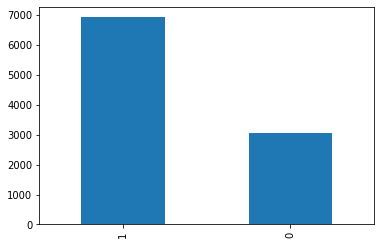

In [12]:
# label 비율 확인, 불균형은 SMOTE로 해겷기
df['label'].value_counts().plot.bar()
print(df['label'].value_counts())

## Preprocessing

In [13]:
# NA 확인
df.isna().sum()

star       0
comment    0
label      0
dtype: int64

In [14]:
# comment가 없는 경우 제외
df = df[df['comment']!='']
df.sample(10)

,star,comment,label
8257,1,재미있게 잘 봤습니다.,0
9236,4,나쁜거부터 배우는 AI 발상까진 좋았으나 무리한 설정과 허술한 전개로 많은 아쉬움을...,0
3487,9,내가 나름 sf 매니아인데 이영화 보통이 아님...기억에 남는 작품,1
1912,10,와 지금봐도 명작이다..,1
25,10,묘한 매력이 있는 영화 매력적인 여배우,1
2747,7,돌아가야만 했던 한 군인의 처절한 생존기,1
5985,10,이렇게 오랬동안 기억이 남고 인상깊었던 영화는 이게처음 이었다,1
2928,8,명대사 제조기 최동훈 감독의 신화는 이 영화에서 시작되었다,1
1355,8,ost 너무 좋다... 앙상블도 훌륭함,1
6946,2,최악입니다 시간아까워요,0


In [15]:
# 한글,공백 제외하고 제거
df['comment'] = df['comment'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
df.sample(5)

C:\Users\User\AppData\Local\Temp/ipykernel_18948/2958532500.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df['comment'] = df['comment'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")


,star,comment,label
2680,7,성공한 영화감독이 자신의 옛이야기를 들려주며 고향에 은혜를 갚다,1
1945,10,김래원 연기 잘하네요,1
2858,10,나도 되돌아갈 힘을 남겨두지 않을정도로 어딘가에 몰입하고 싶다,1
3368,10,내 인생영화 절대 못 잊을거 같당 ㅠㅠㅠ,1
4560,10,영화가 매력이 넘치네요 스토리도 매력 넘치고여주들도 매력 넘치고 추천드립니다,1


In [20]:
df.to_csv('crawling_review.csv')

### Stopword

In [16]:
# https://www.ranks.nl/stopwords/korean
stopword = pd.read_csv('stopword.csv')
stopword = list(stopword['stopdword'].values)
print(stopword[:5])

['아', '휴', '아이구', '아이쿠', '아이고']
